shape for each channel.
(352366, 32, 32, 8)
(352366, 32, 32, 10)
(352366, 17)
------------------------------------------------------------
validation part
(24119, 32, 32, 8)
(24119, 32, 32, 10)
(24119, 17)
show class distribution
[ 5068. 24431. 31693.  8651. 16493. 35290.  3269. 39326. 13584. 11954.
 42902.  9514.  9165. 41377.  2392.  7898. 49359.]


Text(0.5,1,'class distribution')

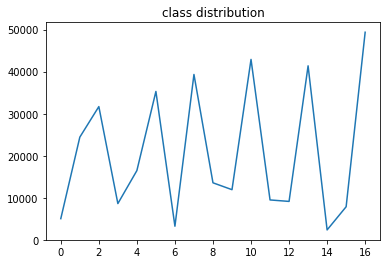

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt

base_dir = "/home/jpbreuer/alibaba-ai/"
path_training = os.path.join(base_dir, "training.h5")
path_test = os.path.join(base_dir, "validation.h5")

fid_training = h5py.File(path_training,'r')
fid_validation = h5py.File(path_test,'r')

print("shape for each channel.")
s1_training = fid_training['sen1']
print(s1_training.shape)
s2_training = fid_training['sen2']
print(s2_training.shape)
label_training = fid_training['label']
print(label_training.shape)

print("-" * 60)
print("validation part")
s1_validation = fid_validation['sen1']
print(s1_validation.shape)
s2_validation = fid_validation['sen2']
print(s2_validation.shape)
label_validation = fid_validation['label']
print(label_validation.shape)

print("show class distribution")
label_qty = np.sum(fid_training["label"], axis=0)
print(label_qty)
plt.plot(label_qty)
plt.title("class distribution")

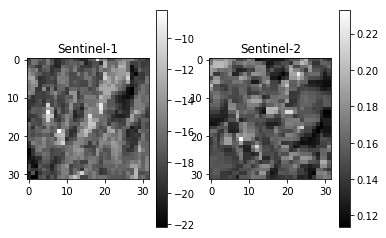

In [3]:
# visualization, plot the first pair of Sentinel-1 and Sentinel-2 patches of training.h5
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(10*np.log10(s1_training[0,:,:,4]),cmap=plt.cm.get_cmap('gray'));
plt.colorbar()
plt.title('Sentinel-1')

plt.subplot(122)
plt.imshow(s2_training[0,:,:,1],cmap=plt.cm.get_cmap('gray'));
plt.colorbar()
plt.title('Sentinel-2')

plt.show()

### as you can see, it is difficult to identify the image as a class by human.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## for a small dataset train and test

train_s1 = np.array(fid_training['sen1'])
train_s2 = np.array(fid_training['sen2'])
train_label = np.array(fid_training['label'])
train_y = np.argmax(train_label, axis=1)


validation_s1 = np.array(fid_validation['sen1'])
validation_s2 = np.array(fid_validation['sen2'])
validation_label = np.array(fid_validation['label'])
validation_y = np.argmax(validation_label, axis=1)


n = train_s1.shape[0]
train_s1 = train_s1.reshape((n, -1))
train_s2 = train_s2.reshape((n, -1))
train_X = np.hstack([train_s1, train_s2])

n = validation_s1.shape[0]
validation_s1 = validation_s1.reshape((n, -1))
validation_s2 = validation_s2.reshape((n, -1))
validation_X = np.hstack([validation_s1, validation_s2])

clf = RandomForestClassifier()
clf.fit(train_X, train_y)
pre_val_y = clf.predict(validation_X)

print(classification_report(validation_y, pre_val_y))


/usr/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


MemoryError: 

In [ ]:
### simple classification example
### Training part using batch

from sklearn.linear_model import SGDClassifier

train_s1 = s1_training
train_s2 = s2_training
train_label = label_training
clf = SGDClassifier()

train_y = np.argmax(train_label, axis=1)
classes = list(set(train_y))
batch_size = 100
n_sampels = train_s1.shape[0]

for i in range(0, n_sampels, batch_size):
    ## this is an idea for batch training
    ## you can relpace this loop for deep learning methods
    if i % batch_size * 10 == 0:
        print("done %d/%d" % (i, n_sampels))
    start_pos = i
    end_pos = min(i + batch_size, n_sampels)
    train_s1_batch = np.asarray(train_s1[start_pos:end_pos, :, :, :])
    train_s2_batch = np.asarray(train_s2[start_pos:end_pos, :, :, :])
    cur_batch_size = train_s2_batch.shape[0]
    train_s1_batch = train_s1_batch.reshape((cur_batch_size, -1))
    train_s2_batch = train_s2_batch.reshape((cur_batch_size, -1))
    train_X_batch = np.hstack([train_s1_batch, train_s2_batch])
    label_batch = train_y[start_pos:end_pos]
    clf.partial_fit(train_X_batch, label_batch, classes=classes)

done 0/352366
done 100/352366
done 200/352366


/usr/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [ ]:
### make a prediction on validation
pred_y = []
train_val_y = np.argmax(label_validation, axis=1)
batch_size = 100
n_val_samples = s2_validation.shape[0]
for i in range(0, n_val_samples, batch_size):
    start_pos = i
    end_pos = min(i + batch_size, n_val_samples)
    val_s1_batch = np.asarray(s1_validation[start_pos:end_pos, :, :, :])
    val_s2_batch = np.asarray(s2_validation[start_pos:end_pos, :, :, :])
    cur_batch_size = val_s2_batch.shape[0]
    val_s1_batch = val_s1_batch.reshape((cur_batch_size, -1))
    val_s2_batch = val_s2_batch.reshape((cur_batch_size, -1))
    val_X_batch = np.hstack([val_s1_batch, val_s2_batch])
    tmp_pred_y = clf.predict(val_X_batch)
    pred_y.append(tmp_pred_y)
pred_y = np.hstack(pred_y)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(train_val_y, pred_y))